# Flood Image Classification Model · From Single Fixed Camera History

---

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


#### General purpose parameters

In [2]:
random_state = 0 # seed for random generator
replacement = False

#### Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

#### Function to binarize target variable class labels

In [4]:
replace_tags = {
    'acúmulo': ['lâmina', 'bolsão', 'alagamento'],
    'normalidade': ['poça', 'normalidade'],
}

def binarize(labels, replace_tags=replace_tags):
    y_true = []
    for tag in labels:
        for key, values in replace_tags.items():
            if tag in values: y_true.append(key)

    return pd.Series(y_true, index=labels.index)

#### Class to load frames from labeled videos as labeled images

In [5]:
import os, cv2, numpy as np
from IPython.display import clear_output as co

class FrameLoader:
        
    def __init__(self, dim=3):
        """  """
        self.dim = dim
        
    def frames_from_labeled_videos(self, paths, labels, print_each=None):
        i, n  = 0, max(len(paths), len(labels))
        x, y = [], []
        for path, label in zip(paths, labels):
            frames = self.frames_from_video(path)
            x += frames;
            y += [label] * len(frames)
            i += 1
            if print_each is not None and i % print_each == 0:
                co(True); print(f'CAPTURE LABELED VIDEOS · OPEN: {i}/{n}')
        return np.array(x), np.array(y)
        
    def frames_from_video(self, path):
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            print(f"CANNOT OPEN VIDEO CAPTURE · PATH: {path}")
            return []
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break # stream finished
            if self.dim == 1: # 1D flat frame
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = np.reshape(frame, -1)
            if self.dim == 2: # 2D gray scale frame
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        cap.release(); cv2.destroyAllWindows()
        return frames

#### Function to display train and test classes counting

In [6]:
import pandas as pd

def split_class_count(y_train, y_test):
    display(pd.concat([
        pd.Series(y_train).value_counts().to_frame('Train set'),
        pd.Series(y_test).value_counts().to_frame('Test set')
    ], axis=1))

#### Function to display mislabeled images

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def display_mislabeled_images(X_test, y_test, y_pred, display_max=5, random=True, img_shape=(854, 480), n_cols=3):

    error_msk = y_test != y_pred
    n_mis = error_msk.sum()

    x_test_mis = X_test[error_msk]
    y_test_mis = y_test[error_msk]
    y_pred_mis = y_pred[error_msk]

    n_imgs = min(n_mis, display_max)

    index_show = list(range(n_imgs))
    if random:
        index_show = np.random.choice(index_show, size=n_imgs, replace=False)

    mis_samples = x_test_mis[index_show]
    mis_labels = y_test_mis.iloc[index_show]
    mis_preds = y_pred_mis[index_show]

    n_rows = n_imgs // n_cols + 1
    fig = plt.figure(figsize=(6 * n_cols, 4.5 * n_rows))
    axs = [fig.add_subplot(n_rows, n_cols, i) for i in range(1, n_imgs + 1)]

    for i, (xi, yi, ypi, tstamp) in enumerate(zip(mis_samples, mis_labels, mis_preds, mis_labels.index)):
        ax = axs[i]
        img_reshape = np.reshape(xi, tuple(reversed(img_shape)))
        ax.imshow(img_reshape)
        ax.set(title=f'{tstamp} · True: {yi} · Predicted: {ypi}')
        
    plt.show()

---
### Reload labeled flood videos dataset

In [26]:
import pandas as pd

code = 1649 # 1648 # 1487

videos = pd.read_csv(f'Dados/Rotulados/videos_labeled_CODE{code}_2023-04-29.csv')

# preprocessing
videos['timestamp'] = pd.to_datetime(videos['timestamp'])
videos = videos.set_index('timestamp', drop=True).sort_index()

# drop videos larger than `video_max_bytes`
video_max_bytes = 5e6 # 5 Mb
# videos = videos[videos['blob_size'] < video_max_bytes]

display(videos[['blob_name', 'tag']].head())
print(f'Shape: {videos.shape}')

mega_bytes = round(videos["blob_size"].sum() / 1e6, 3)
print(f'\nTotal video bytes: {mega_bytes} Mb')

,blob_name,tag
timestamp,,
2023-02-07 19:25:00,polygons/flood-unlabeled/19/1649/CODE1649 2023...,poça
2023-02-07 19:30:00,polygons/flood-unlabeled/19/1649/CODE1649 2023...,poça
2023-02-07 19:35:00,polygons/flood-unlabeled/19/1649/CODE1649 2023...,lâmina
2023-02-07 19:40:00,polygons/flood-unlabeled/19/1649/CODE1649 2023...,lâmina
2023-02-07 19:50:00,polygons/flood-unlabeled/19/1649/CODE1649 2023...,lâmina


Shape: (199, 8)

Total video bytes: 197.291 Mb


---
### Reload labeled flood images dataset

In [27]:
import pandas as pd

# code = 1648 # 1487
image_max_bytes = 5e6 # 5 Mb

images = pd.read_csv(f'Dados/Rotulados/images_labeled_CODE{code}_2023-04-29.csv')

# preprocessing
images['timestamp'] = pd.to_datetime(images['image_timestamp'])
images = images.set_index('image_timestamp', drop=True).sort_index()

# drop images larger than `video_max_bytes`
# image_max_bytes = 5e6 # 5 Mb
# images = images[images['blob_size'] < image_max_bytes]

display(images[['blob_name', 'tag']].head())
print(f'Shape: {images.shape}')

# mega_bytes = round(images["blob_size"].sum() / 1e6, 3)
# print(f'\nTotal video bytes: {mega_bytes} Mb')

,blob_name,tag
image_timestamp,,
2023-02-07 19:25:00.000,polygons/flood-unlabeled/19/1649/CODE1649 2023...,poça
2023-02-07 19:25:00.333,polygons/flood-unlabeled/19/1649/CODE1649 2023...,poça
2023-02-07 19:25:00.667,polygons/flood-unlabeled/19/1649/CODE1649 2023...,poça
2023-02-07 19:25:01.000,polygons/flood-unlabeled/19/1649/CODE1649 2023...,poça
2023-02-07 19:25:01.333,polygons/flood-unlabeled/19/1649/CODE1649 2023...,poça


Shape: (8339, 9)


---
## Video Data Preprocessing

#### Optional · Binarize videos class labels

In [28]:
replace_tags = {
    'acúmulo': ['lâmina', 'bolsão', 'alagamento'],
    'normalidade': ['poça', 'normalidade'],
}

y_true = binarize(videos['tag'], replace_tags)

videos['label'] = y_true

display(videos['tag'].value_counts().to_frame('Video Tags'))
display(videos['label'].value_counts().to_frame('Video Binarized Labels'))

,Video Tags
normalidade,186
lâmina,8
poça,2
alagamento,2
bolsão,1


,Video Binarized Labels
normalidade,188
acúmulo,11


---
## Optional · Video Data Sampling

#### Optional · Under sampling videos from majority class · Drop exceeding class members

In [29]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 1.0

# True class labels
# y_true = videos['tag']

# Sampler instance
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state, replacement=replacement)

# Resample operation
x_res, y_res = rus.fit_resample(videos, y_true)

display(y_res.value_counts().to_frame('Videos Sub-sample'))

,Videos Sub-sample
acúmulo,11
normalidade,11


#### Optional · Train and test split of video samples

In [30]:
from sklearn.model_selection import train_test_split

t_size = 0.5  # 0.25 recommended after under-sample
e_size = 0.5  # 0.25 recommended after under-sample

# True class labels
# y_true = videos['tag']

X, Y = x_res, y_res  # pre-sampled
# X, Y = videos, y_true  # complete set of videos

xt, xe, yt, ye = train_test_split(
    X, Y, test_size=e_size, train_size=t_size,
    random_state=random_state, shuffle=True,
    stratify=Y
)

# complete x and y sequences
yy = pd.concat([yt, ye], axis=0)
xx = pd.concat([xt, xe], axis=0)

split_class_count(yt, ye)
display(yy.value_counts().to_frame('Video Samples'))

,Train set,Test set
normalidade,6,5
acúmulo,5,6


,Video Samples
acúmulo,11
normalidade,11


---
## Load images and class labels from selected labeled videos

In [31]:
folder = 'Dados/flood-video-collection'

LABEL_TYPE = 'IMAGE_LABEL'

XX, YY = x_res, y_res  # pre-sampled from loaded videos dataset
# XX, YY = xx, yy  # pre-sampled from loaded videos dataset
# XX, YY = videos, y_true  # complete set of frames from loaded videos dataset

videos_paths = [f'{folder}/{blob_name}'.replace(':', '-') for blob_name in XX['blob_name']]
videos_labels = YY.tolist()

video_loader = FrameLoader(dim=1)
frames, labels = video_loader.frames_from_labeled_videos(videos_paths, videos_labels, print_each=1)

if LABEL_TYPE == 'IMAGE_LABEL':
    labels = pd.concat([images[images['blob_name']==blob_name].sort_values('image_timestamp')['tag'] for blob_name in  XX['blob_name']])
    labels = binarize(labels, replace_tags)
    frames = pd.DataFrame(frames, index=labels.index)
    
print(f'\nVideos Selected: {len(XX)}')
print(f'Frames Loaded: {len(frames)}')
print(f'Length of frame first dimension: {len(frames[0])}')
print()

display(pd.Series(labels).value_counts().to_frame('Image Samples'))

CAPTURE LABELED VIDEOS · OPEN: 22/22

Videos Selected: 22
Frames Loaded: 1753
Length of frame first dimension: 1753



,Image Samples
acúmulo,1428
normalidade,325


---
## Image Data Sampling

#### Under sampling images from majority class · Drop exceeding class members

In [32]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 1.0

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state, replacement=replacement)

X_res, Y_res = rus.fit_resample(frames, labels)
Y_res = pd.Series(Y_res)

display(Y_res.value_counts().to_frame('Images Under-Sampled'))

,Images Under-Sampled
acúmulo,325
normalidade,325


In [33]:
frames = None  # clear memory

---
## Image Classification Model Evaluation

#### Train and test split of image samples

In [45]:
t_size = 0.1
e_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(
    X_res, Y_res, train_size=t_size, test_size=e_size,
    random_state=random_state, shuffle=True,
    stratify=Y_res
    # stratify=labels
)

split_class_count(y_train, y_test)

,Train set,Test set
normalidade,33,65
acúmulo,32,65


In [38]:
# X_res, Y_res = None, None  # clear memory

#### Fit, predict and score base image classifier

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import numpy as np

gnb = GaussianNB()
model = gnb

# lr = LinearRegression()
# model = lr

# fit model


# make prediction
y_pred = model.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total of %d points : %d\n"
      % (X_test.shape[0], (y_test != y_pred).sum()))

# print("Total difference:",  round(np.abs(y_test - y_pred).sum(), 4))
# print("Average difference:",  round(np.abs(y_test - y_pred).sum() / len(y_test)))

print(classification_report(y_test, y_pred))

Number of mislabeled points out of a total of 130 points : 20

              precision    recall  f1-score   support

     acúmulo       0.98      0.71      0.82        65
 normalidade       0.77      0.98      0.86        65

    accuracy                           0.85       130
   macro avg       0.87      0.85      0.84       130
weighted avg       0.87      0.85      0.84       130



#### Prediction difference distribution

In [ ]:
ax = (y_test - y_pred).hist()

#### Save base model for camera code 

In [47]:
import pickle

# model = gnb
file_name = f'models/code{code}.sav'

pickle.dump(model, open(file_name, 'wb')) # save the model to disk

#### Display mislabeled images

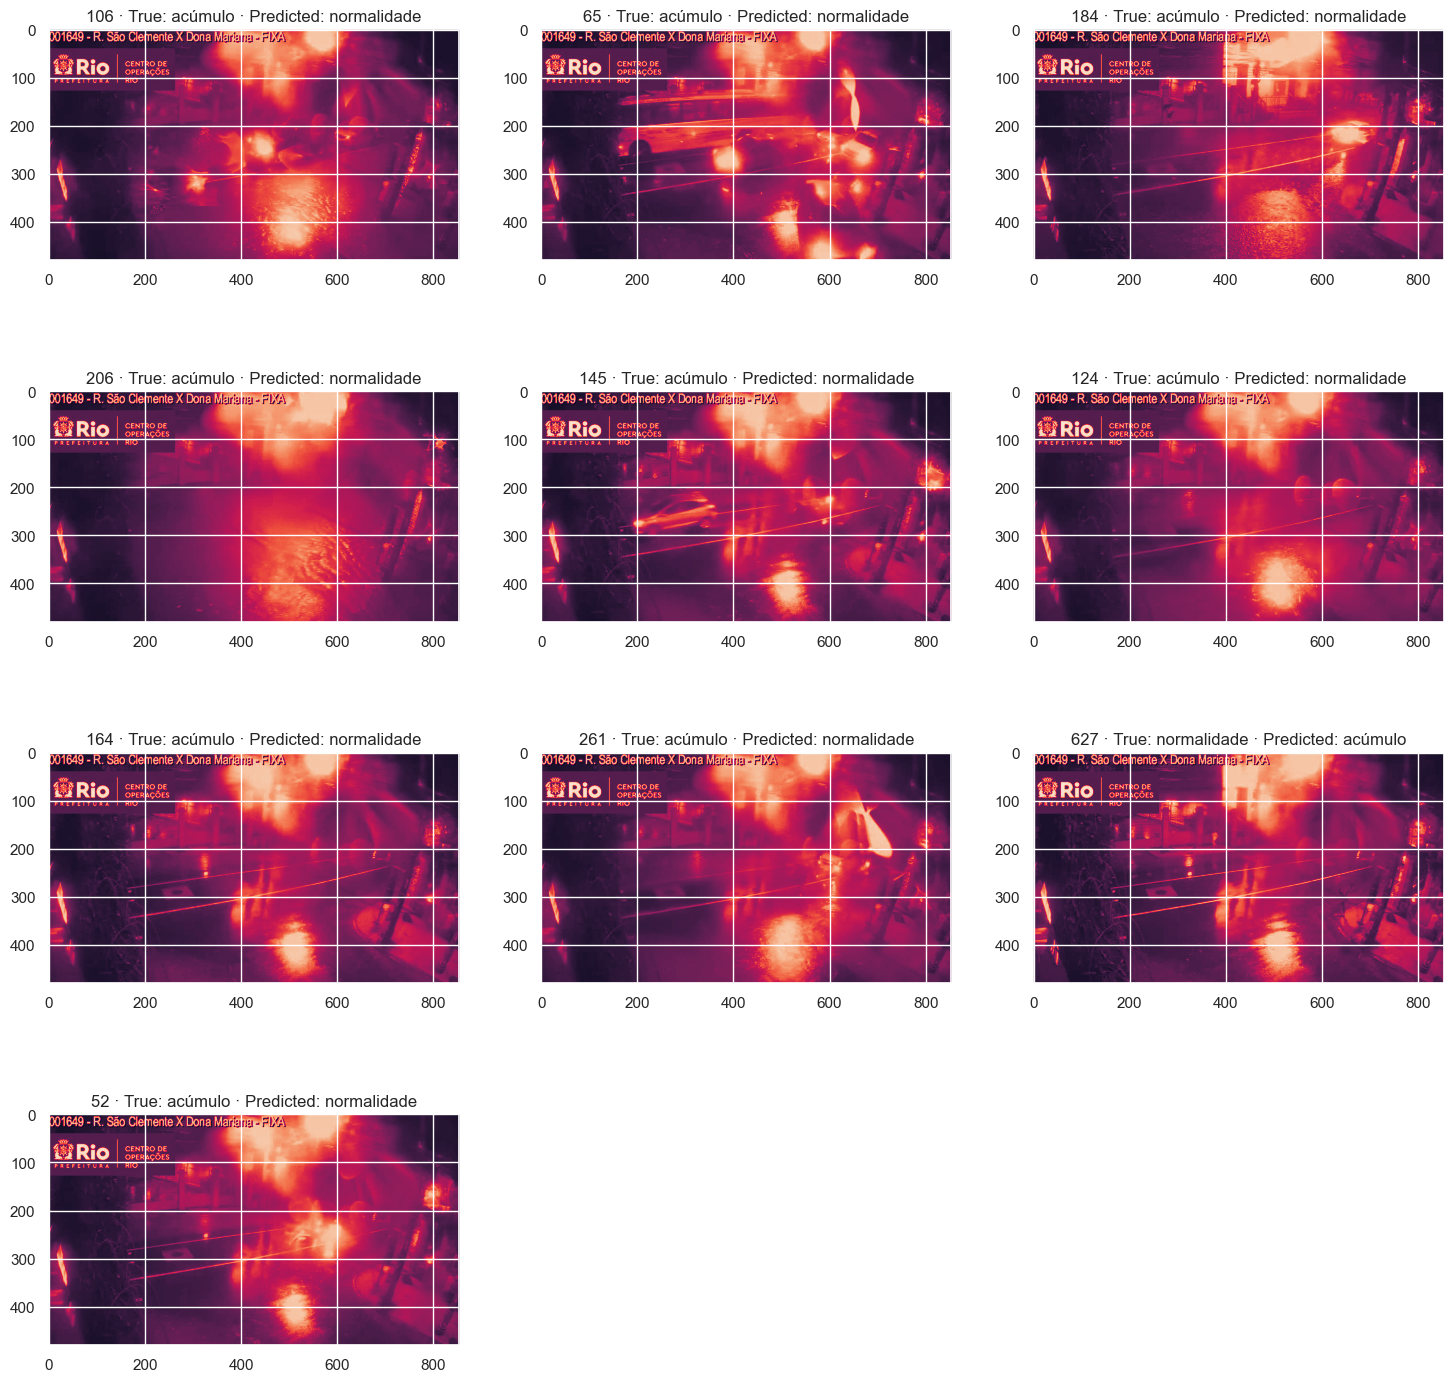

In [48]:
n_cols = 3
display_max = 10
random = True

display_mislabeled_images(X_test.values, y_test, y_pred, display_max, random, n_cols=n_cols)

---
## Learning Curve Analysis

#### Train test split image samples

In [62]:
t_size = 0.1
e_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X_res, Y_res, train_size=t_size, test_size=e_size,
    random_state=random_state, shuffle=True, stratify=Y_res
)

split_class_count(y_train, y_test)

,Train set,Test set
acúmulo,8,17
normalidade,8,17


#### Increase train size iteratively · Learning Curve Plot

[learning_curve] Training set sizes: [ 4 13 23 33 43]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   51.8s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.7min remaining:   49.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.0min finished


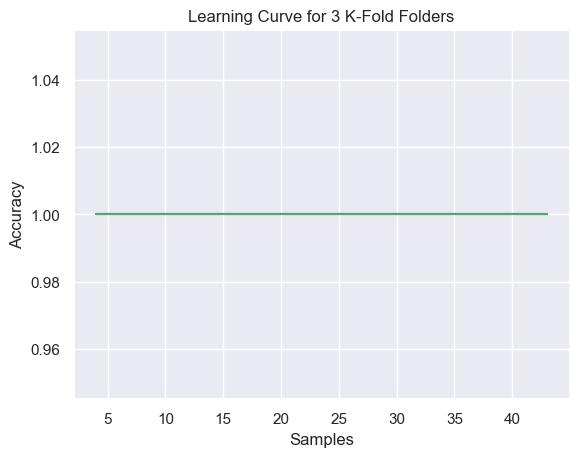

In [49]:
from sklearn.model_selection import learning_curve

cv = 3

curve = learning_curve(model, X_train, y_train,  cv=cv, verbose=3, n_jobs=-1, shuffle=False)

axs = plt.plot(curve[0], curve[1])
plt.title(f'Learning Curve for {cv} K-Fold Folders')
plt.ylabel('Accuracy')
plt.xlabel('Samples')
plt.show()

Note: Unexpectedly, for code 1475, the accuracy for each of the splits' test folders increases as the number of training samples decreases. Choose the appropriate number of training samples on the cell below based on the chart above.

---
## Predict entire dataset · Real Conditions Simulation

#### Optional · Train and test split of video samples

In [100]:
from sklearn.model_selection import train_test_split

t_size = 0.25
e_size = 0.25

# X, Y = x_res, y_res  # pre-sampled
X, Y = videos, y_true  # complete set of videos

xt, xe, yt, ye = train_test_split(
    X, Y, test_size=e_size, train_size=t_size,
    random_state=random_state, shuffle=True, stratify=Y
)

# complete x and y sequences
yy = pd.concat([yt, ye], axis=0)
xx = pd.concat([xt, xe], axis=0)

split_class_count(yt, ye)
display(yy.value_counts().to_frame('Complete set'))

,Train set,Test set
normalidade,31,32
acúmulo,9,9


,Complete set
normalidade,63
acúmulo,18


#### Load images and class labels from selected videos

In [101]:
folder = 'Dados/flood-video-collection'

XX, YY = xx, yy  # pre-sampled from loaded videos dataset
# XX, YY = videos, y_true  # complete set of frames from loaded videos dataset

videos_paths = [f'{folder}/{blob_name}'.replace(':', '-') for blob_name in XX['blob_name']]
videos_labels = YY.tolist()

video_loader = FrameLoader(dim=1)
frames, labels = video_loader.frames_from_labeled_videos(videos_paths, videos_labels, print_each=1)

print(f'\nVideos Selected: {len(XX)}')
print(f'Frames Loaded: {len(frames)}')
print(f'Length of frame first dimension: {len(frames[0])}')
print()

display(pd.Series(labels).value_counts().to_frame('Image Samples'))

CAPTURE LABELED VIDEOS · OPEN: 81/81

Videos Selected: 81
Frames Loaded: 2692
Length of frame first dimension: 409920



,Image Samples
normalidade,2150
acúmulo,542
